In [36]:
# Cell 1 — Imports & Constants
import os
import pickle
import numpy as np
import h5py
from scipy.io import loadmat
from mne import create_info
from mne.io import RawArray
import matplotlib.pyplot as plt

# Adjust these paths if your working directory is different:
ROOT       = "/vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation"
TARGET_FREQ = 500  # Hz

mat_path = os.path.join(ROOT, "Matlab_data_processed", "Patient2", "day5.mat")
pkl_path = os.path.join(ROOT, "processed_data", "labels", "Patient2_day5_intervals_new.pkl")
# h5_path  = os.path.join(ROOT, "processed_data", "session_data", "P1_D3_Tsymptom_provocation_SUPENNS001R01.h5")

h5_path  = os.path.join(ROOT, "processed_data", "session_data", "P2_D5_Tsymptom_provocation_SUPENNS001R01.h5")

trial_idx = 0 #which trial to process




In [37]:
# Cell 2 — Load MATLAB trial (supports v7.3 via h5py fallback)
def load_matlab_trial(mat_path, trial_idx):
    """
    Returns (trial_array, fsample) for trial_idx.
    For v7.3 files, uses h5py; otherwise uses scipy.loadmat.
    Also saves the loaded ftdata struct to the global `ft` variable.
    """
    try:
        # Try scipy loadmat (v7.2 and earlier)
        m = loadmat(mat_path, struct_as_record=False, squeeze_me=True)
        global ft
        ft = m.get('ftdata') or m.get('ftData')
        trials = ft.trial
        fs = float(ft.fsample)
        return trials[trial_idx], fs
    except NotImplementedError:
        # Fallback for v7.3
        with h5py.File(mat_path, 'r') as f:
            grp = f.get('ftdata') or f.get('ftData')
            # object references to each trial dataset
            refs = grp['trial'][()]
            fs = float(np.array(grp['fsample']).item())
            trials = [np.array(f[r]).T for r in refs.flatten()]
        # cannot set ft for v7.3 via loadmat, but we'll still return trial & fs
        return trials[trial_idx], fs

# Actually load trial 0
trial_mat, fs_mat = load_matlab_trial(mat_path, trial_idx)
print(f"Loaded MATLAB trial: shape={trial_mat.shape}, fs={fs_mat:.1f} Hz")

Loaded MATLAB trial: shape=(192, 72000), fs=1200.0 Hz


In [38]:
# Cell 3 — Load intervals
with open(pkl_path, 'rb') as f:
    iv = pickle.load(f)
starts = np.asarray(iv.start)
ends   = np.asarray(iv.end)
start_sec = starts[trial_idx]
end_sec   = ends[trial_idx]
print(f"Trial {trial_idx}: start={start_sec:.2f}s, end={end_sec:.2f}s")


Trial 0: start=1763.66s, end=1823.66s


In [39]:

# Cell 4 — Extract HD5 segment at 500 Hz with sanity check
with h5py.File(h5_path, 'r') as f:
    ieeg = f['ieeg/data']
    # Sanity check: print the original dimensions
    print("HD5 raw ieeg/data shape:", ieeg.shape)
    
    start_idx = int(start_sec *TARGET_FREQ) 
    end_idx   = int(end_sec   * TARGET_FREQ)
    
    # Handle either 2-D or 3-D layouts
    if ieeg.ndim == 3:
        # shape likely (1, channels, samples)
        seg_hd5 = ieeg[0, :, start_idx:end_idx]
    else:
        # shape likely (channels, samples)
        seg_hd5 = ieeg[:, start_idx:end_idx]

print(f"HD5 segment shape: {seg_hd5.shape}")



HD5 raw ieeg/data shape: (1, 178, 1080200)
HD5 segment shape: (178, 30000)


In [40]:
# Cell 5 — Bipolar‐reference MATLAB trial using the electrode CSV, then downsample to 500 Hz

import pandas as pd

# 5a) Load the original electrode names for Patient 1
elec_csv    = os.path.join(ROOT, "original_data", "electrodes_all_subj1.csv")
elec_df     = pd.read_csv(elec_csv)
ch_names_mat = elec_df['name'].astype(str).tolist()   # length 176

# 5b) Build the “contiguity” mask exactly as     script
mask       = [
    (ch_names_mat[i][:2] == ch_names_mat[i+1][:2]) and (ch_names_mat[i] != "nan")
    for i in range(len(ch_names_mat)-1)
]
contig_idx = np.where(mask)[0]        # indices of True entries (should be 162)

# 5c) Compute successive‐channel differences and keep only contiguous pairs
diff_mat = (trial_mat[1:, :] - trial_mat[:-1, :])[contig_idx, :]
n_chan   = diff_mat.shape[0]          # now 162

# 5d) Update channel names to the first contact of each bipolar pair
final_ch_names = [ch_names_mat[i] for i in contig_idx]

print(f">>> After bipolar reref: diff_mat shape = {diff_mat.shape}, channels = {len(final_ch_names)}")

# 5e) Wrap in MNE RawArray and downsample to TARGET_FREQ
info     = create_info(ch_names=final_ch_names, sfreq=fs_mat, ch_types=['eeg']*n_chan)
raw      = RawArray(diff_mat, info)
raw.resample(TARGET_FREQ, npad="auto")
trial_ds = raw.get_data()             # shape → (162, n_samp_500)

print(f">>> After downsample: trial_ds shape = {trial_ds.shape}")




>>> After bipolar reref: diff_mat shape = (162, 72000), channels = 162
Creating RawArray with float64 data, n_channels=162, n_times=72000
    Range : 0 ... 71999 =      0.000 ...    59.999 secs
Ready.
>>> After downsample: trial_ds shape = (162, 30000)


In [41]:
# Cell 6 — Trim both arrays to the same length
min_len = min(trial_ds.shape[1], seg_hd5.shape[1])
trial_ds = trial_ds[:, :min_len]
seg_hd5   = seg_hd5[:, :min_len]
print(f"Trimmed to {min_len} samples")


Trimmed to 30000 samples


In [42]:
# Cell 7 — Sanity‐check shapes & compute channel×channel Pearson r
print("trial_ds.shape:", trial_ds.shape)
print("seg_hd5.shape: ", seg_hd5.shape)
        
# X: HD5 data (162 channels × T), Y: MATLAB data (176 channels × T)
X = seg_hd5
Y = trial_ds

# 1) Stack along channel dimension
Z = np.vstack([X, Y])                   # shape (162+176, T)

# 2) Compute full correlation matrix
C_full = np.corrcoef(Z)                 # shape (338, 338)

# 3) Extract the cross‐block (HD5 vs MATLAB) correlations
corr = C_full[: X.shape[0], X.shape[0]:] # shape (162, 176)

print("Computed correlation matrix shape:", corr.shape)

trial_ds.shape: (162, 30000)
seg_hd5.shape:  (178, 30000)
Computed correlation matrix shape: (178, 162)


Saved correlation matrix to corr_P1_D3_trial0.npy


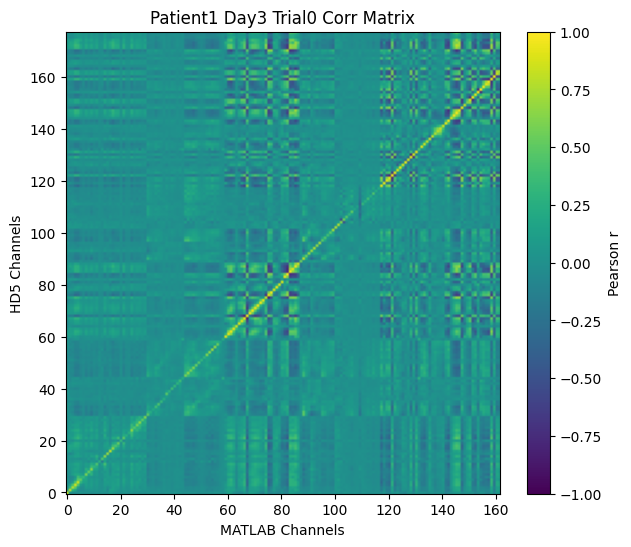

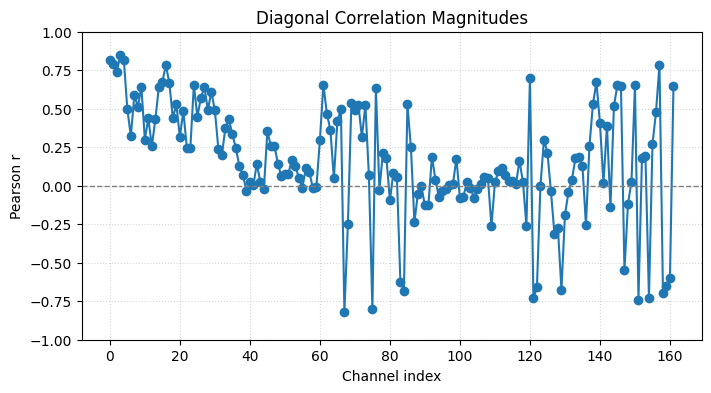

In [43]:
# Cell 8 — Save & visualize the correlation matrix
out_name = f"corr_P1_D3_trial{trial_idx}.npy"
np.save(out_name, corr)
print("Saved correlation matrix to", out_name)

plt.figure(figsize=(7,6))
plt.imshow(corr, aspect='auto', origin='lower', vmin=-1, vmax=1)
plt.colorbar(label='Pearson r')
plt.title(f'Patient1 Day3 Trial{trial_idx} Corr Matrix')
plt.imshow(corr, aspect='auto', origin='lower', vmin=-1, vmax=1)
plt.xlabel('MATLAB Channels')
plt.ylabel('HD5 Channels')

plt.show()



diag = np.diag(corr)

plt.figure(figsize=(8, 4))
plt.plot(diag, marker='o', linestyle='-')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Channel index')
plt.ylabel('Pearson r')
plt.title('Diagonal Correlation Magnitudes')
plt.ylim(-1, 1)
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()